In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba as nb

In [98]:
@nb.njit
def update_low( N, s, nn, beta, J, h ):
    
    # size 1 flip
    for _ in range(N*N):

        xy = np.random.randint(0,N*N)

        sum_s_j = s[nn[xy,0]] + s[nn[xy,1]] + s[nn[xy,2]] + s[nn[xy,3]]

        delta_H = 2 * s[xy] * ( sum_s_j * J + h )

        delta_S = np.exp( - beta * delta_H )

        if delta_H < 0 or np.random.uniform(0.0,1.0) < delta_S:
            
            s[xy] *= -1
    

class Ising:
    
    def __init__(self, N, J, h):
        self.N = N
        self.J = J
        self.h = h
        self.s = np.zeros((N*N), int)
        self.nn = np.zeros((N*N,4), int)
        for x in range(N):
            for y in range(N):
                xp = (x + 1) % N
                xm = (x - 1) % N 
                yp = (y + 1) % N 
                ym = (y - 1) % N
                xy = x*N+y
                self.nn[xy,0] = xp*N+y
                self.nn[xy,1] = xm*N+y
                self.nn[xy,2] = x*N+yp
                self.nn[xy,3] = x*N+ym
    
        
    def show(self):
        N = self.N
        plt.imshow(self.s.reshape(N,N))
        plt.show()
        
    def M(self):
        return np.mean( self.s )

    def H( self ):

        N = self.N
        nn = self.nn
        s = self.s
        H = np.zeros_like(s)

        for xy in range(N*N):

            sum_s_j = s[nn[xy,0]] + s[nn[xy,1]] + s[nn[xy,2]] + s[nn[xy,3]]
    
            H[xy] = - s[xy] * ( sum_s_j * self.J + self.h )

        return H.reshape(N,N)

    def Mr( self ):

        N = self.N
        nn = self.nn
        s = self.s
        Mr = np.zeros_like(s).astype(float)

        for xy in range(N*N):

            sum_s_j = s[nn[xy,0]] + s[nn[xy,1]] + s[nn[xy,2]] + s[nn[xy,3]]
    
            Mr[xy] = s[xy] / 2.0 + sum_s_j / 8.0 

        return Mr.reshape(N,N)

    def cold_start(self):
        s0 = 1
        N = self.N
        if 0.5 > np.random.uniform():
            s0 = -1
        
        self.s = s0 + np.zeros((N*N), int)
        
    def hot_start(self):
        N = self.N
        self.s = -1 + 2 * np.random.randint(0,2,N*N)

    def update( self, beta ):
        N = self.N
        nn = self.nn
        s = self.s
        
        update_low( N, s, nn, beta, self.J, self.h )
                
    def thermalize( self, beta, steps ):
#        s0 = self.s.copy()
        
        for step in range(steps):
            self.update( beta )
#            a = self.angle(s0)
#            if a > np.pi / 2 * 
#        print( beta, self.angle(s0) )
    
    def angle( self, other_s ):
        ab = np.dot( self.s, other_s )
        aa = np.dot( self.s, self.s )
        bb = np.dot( other_s, other_s )
        
        cos_ab = ab / np.sqrt(aa*bb)
        if cos_ab >= 1:
            return 0.0
        if cos_ab <= -1:
            return np.pi
        
        return np.arccos( cos_ab )


In [207]:
m = []
b = []
h = []

I = Ising(64, 1.0, 0.0)

for _ in range(10):
    
    I.hot_start()
    I.thermalize( 0.01, 100 )

    for beta in np.linspace( 0.01, 0.7, 32 ):

        I.thermalize( beta, 1000 )

        b.append(beta)
        m.append(I.M())
        h.append(np.mean(I.H()))
        
    for beta in np.linspace( 0.7, 0.01, 32 ):
        I.thermalize( beta, 1000 )
        b.append(beta)
        m.append(I.M())
        h.append(np.mean(I.H()))
        
    print('-', end='')

----------

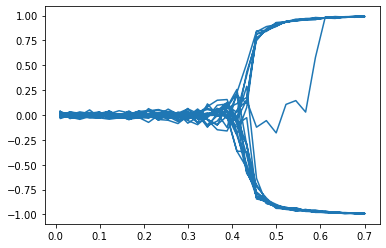

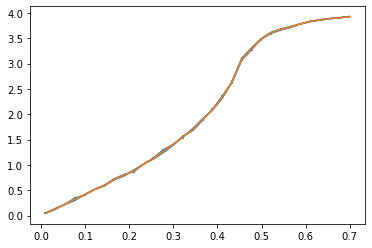

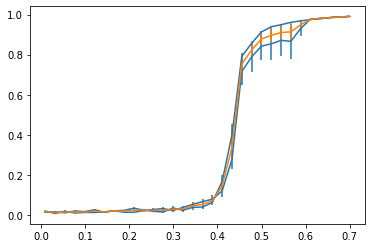

In [208]:
plt.plot(b,m)
plt.show()

b_ = np.array(b).reshape((10,64))
m_ = np.array(m).reshape((10,64))
h_ = np.array(h).reshape((10,64))

beta = np.mean(b_, axis=0)
avem = np.mean( np.abs(m_), axis=0)
stdm = np.std(np.abs(m_), axis=0) / np.sqrt(m_.shape[0])

aveh = np.mean( h_, axis=0)
stdh = np.std(h_, axis=0) / np.sqrt(h_.shape[0])


plt.errorbar( beta, aveh, stdh )
plt.errorbar( r(beta), r(aveh), r(stdh) )
plt.show()

def r(x):
    n = x.size
    n2 = n//2
    return ( x[0:n2:1] + x[n:n2-1:-1] ) / 2.0

plt.errorbar( beta, avem, stdm )
plt.errorbar( r(beta), r(avem), r(stdm) )
plt.show()

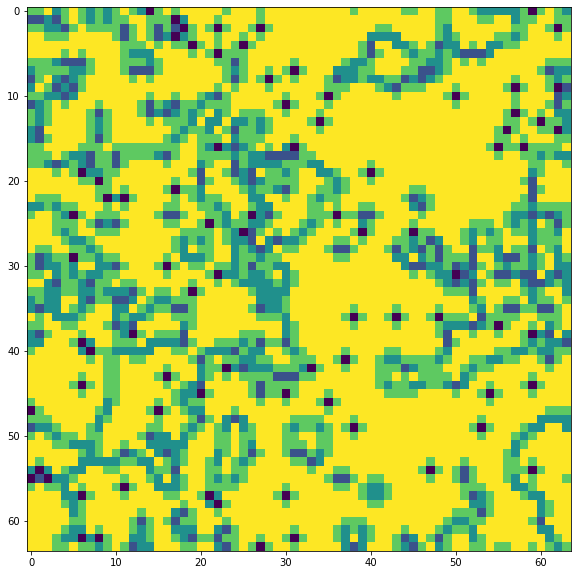

In [215]:
beta_interesting = 0.43
I.hot_start()
for beta in np.linspace( 0.01, beta_interesting, 32 ):
    I.thermalize( beta, 100 )
I.thermalize( beta_interesting, 1000 )

import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

def animate(i):
    I.thermalize( beta_interesting, 1 )
#    plt.imshow(I.Mr())
    plt.imshow(I.H())

fig = plt.figure(figsize=(10,10))
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=100)

from IPython.display import HTML
HTML(ani.to_jshtml())


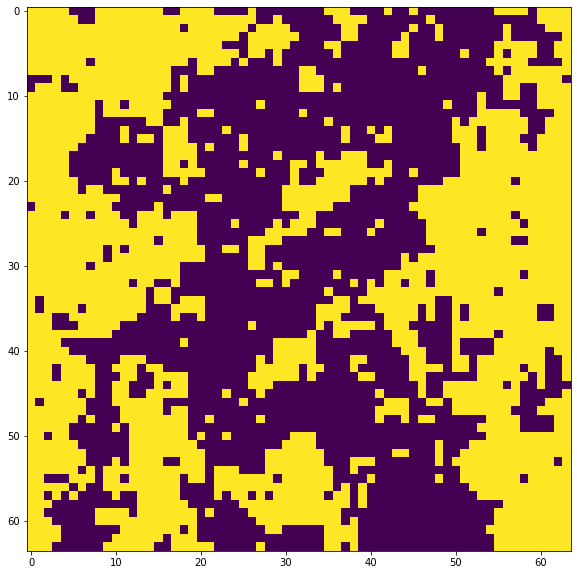

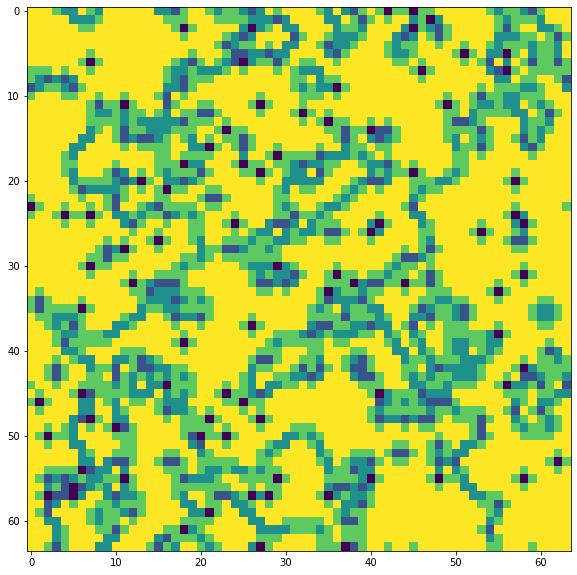

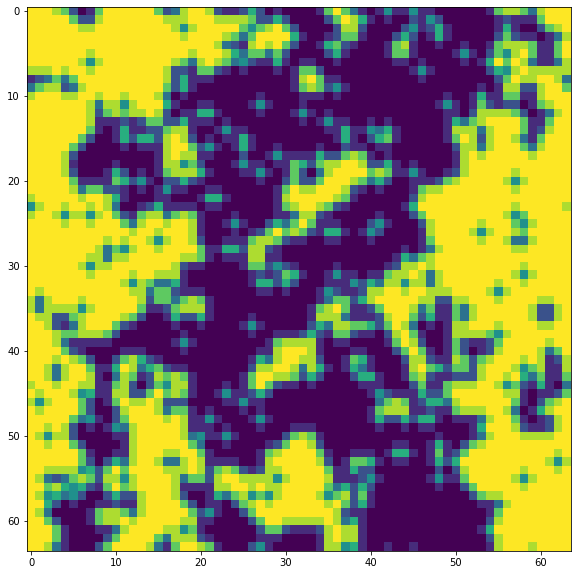

In [213]:

plt.figure(figsize=(10,10))
I.show()

plt.figure(figsize=(10,10))
plt.imshow(I.H())
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(I.Mr())
plt.show()


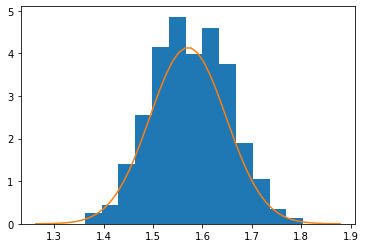

In [201]:
a = []

T = 1000

I1 = Ising(13, -1.0, 1.0)
I2 = Ising(13, -1.0, 1.0)

Nbins = I1.N

for _ in range(T):
    
    I1.hot_start()
    I2.hot_start()

    a.append( I1.angle( I2.s ) )
    
plt.hist(a, bins=Nbins, density=True)


sigma = 1. / I1.N
norm = T / np.sqrt( 2. * np.pi ) / sigma
dx = np.pi / Nbins
x = np.linspace( np.pi/2 - 4*sigma , np.pi/2 + 4*sigma )

y = np.exp( -(x-np.pi/2)**2 / sigma**2 / 2. ) / dx # * norm * dx

plt.plot(x,y)


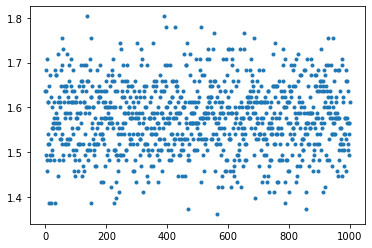

In [202]:
plt.plot(a,'.')

In [126]:
np.sum(y)

6.3528771837471766e+01

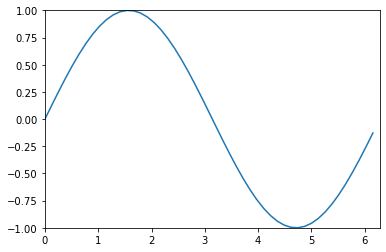

In [179]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
ax.axis([0,2*np.pi,-1,1])
l, = ax.plot([],[])

def animate(i):
    l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

from IPython.display import HTML
HTML(ani.to_jshtml())

In [183]:
I.s.reshape(I.N,I.N)

array([[-1, -1, -1, ...,  1, -1,  1],
       [ 1, -1,  1, ...,  1,  1, -1],
       [ 1,  1, -1, ..., -1,  1, -1],
       ...,
       [ 1,  1, -1, ..., -1,  1,  1],
       [-1,  1, -1, ...,  1, -1,  1],
       [ 1, -1, -1, ...,  1, -1,  1]])